In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

Using TensorFlow backend.


Inline visualization of TensorFlow graph from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
and 
http://sdsawtelle.github.io/blog/output/getting-started-with-tensorflow-in-jupyter.html

In [2]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
        

          

Preprocessing the data

In [55]:
dataset = mnist.load_data()
train_data = dataset[0][0] / 255
train_data = train_data[..., np.newaxis].astype('float32')
train_labels = np_utils.to_categorical(dataset[0][1]).astype('float32')
test_data = dataset[1][0] / 255
test_data = test_data[..., np.newaxis].astype('float32')
test_labels = np_utils.to_categorical(dataset[1][1]).astype('float32')
train_data.shape

In [57]:
train_labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

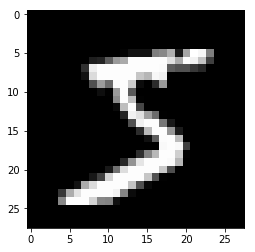

In [58]:
plt.imshow(train_data[0, ..., 0])

Function for providing batches

In [59]:
def get_batch(data, labels, num_samples):
    """Get a random batch of corresponding data and labels of size `num_samples`"""
    idx = np.random.choice(np.arange(0, data.shape[0]), num_samples)
    return data[[idx]], labels[[idx]]

### Definining the TensorFlow model with the `core API`


In [68]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='VALID')

In [69]:
graph_plain = tf.Graph()
with graph_plain.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    with tf.name_scope('conv2d_1'):
        W_conv1 = weight_variable([3, 3, 1, 32])
        b_conv1 = bias_variable([32])
        act_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    with tf.name_scope('max_pooling2d_1'):
        pool1 = max_pool_2x2(act_conv1)
    with tf.name_scope('conv2d_2'):
        W_conv2 = weight_variable([3, 3, 32, 32])
        b_conv2 = bias_variable([32])
        act_conv2 = tf.nn.relu(conv2d(pool1, W_conv2)) + b_conv2
    with tf.name_scope('dropout_1'):
        keep_prob1 = tf.placeholder(tf.float32)
        drop1 = tf.nn.dropout(act_conv2, keep_prob=keep_prob1)
    with tf.name_scope('flatten_1'):
        flatten_1 = tf.reshape(drop1, [-1, 11 * 11 * 32])
    with tf.name_scope('dense_1'):
        W_dense1 = weight_variable([11 * 11 * 32, 64])
        b_dense_1 = bias_variable([64])
        act_dense1 = tf.nn.relu((flatten_1 @ W_dense1) + b_dense_1)
    with tf.name_scope('dropout_2'):
        keep_prob2 = tf.placeholder(tf.float32)
        drop2 = tf.nn.dropout(act_dense1, keep_prob=keep_prob2)
    with tf.name_scope('dense_2'):
        W_dense2 = weight_variable([64, 10])
        b_dense2 = bias_variable([10])
        # Dont use softmax activation function, because tf provides cross entropy only in conjunction with it.
        net_dense2 = (drop2 @ W_dense2) + b_dense2 

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=net_dense2, labels=y_)
        )


    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
    correct_prediction = tf.equal(tf.argmax(net_dense2, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Create init op and saver in the graph, so they can find the variables.
    init_op_plain = tf.global_variables_initializer()    
    saver = tf.train.Saver()

In [62]:
show_graph(graph_plain)

Training loop

In [116]:
sess = tf.Session(graph=graph_plain)    
sess.run(init_op_plain)
for i in range(1000):
    batch = get_batch(train_data, train_labels, 50)
    if i % 100 == 0:
        train_accuracy = sess.run(
            fetches=accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob1: 0.75, keep_prob2: 0.5}
        )
        print('step %d, training accuracy %g' % (i, train_accuracy))
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob1: 0.75, keep_prob2: 0.5})

print('test accuracy %g' % accuracy.eval(feed_dict={x: test_data, y_: test_labels, keep_prob1: 1.0, keep_prob2: 1.0},
                                         session=sess))

step 0, training accuracy 0.02
step 100, training accuracy 0.14
step 200, training accuracy 0.44
step 300, training accuracy 0.48
step 400, training accuracy 0.46
step 500, training accuracy 0.52
step 600, training accuracy 0.58
step 700, training accuracy 0.7
step 800, training accuracy 0.68
step 900, training accuracy 0.72
test accuracy 0.8971


In [117]:
# Save the model including weights.
saver.save(sess, 'tf_mnist_model_plain/tf_mnist_model.ckpt')
sess.close()

### Definining the TensorFlow model with the  `tf.layers` API.

In [112]:
graph_layers = tf.Graph()
with graph_layers.as_default():
    
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    training = tf.placeholder_with_default(False, shape=(), name='training') # Switch for dropout layers.

    
    t = tf.layers.conv2d(x, filters=32, kernel_size=(3 ,3), activation=tf.nn.relu, 
                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         name='conv2d_1')

    t = tf.layers.max_pooling2d(t, pool_size=(2, 2), strides=(2, 2),
                                name='max_pooling2d_1')
    t = tf.layers.conv2d(t, filters=32, kernel_size=(3, 3), activation=tf.nn.relu,
                        kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                        name='conv2d_2')
    t = tf.layers.dropout(t, rate=0.25, training=training, name='dropout_1')
    t = tf.contrib.layers.flatten(t)
    # Dense does not really flatten, but behaves like tensordot 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.tensordot.html
    # https://github.com/tensorflow/tensorflow/issues/8175
    t = tf.layers.dense(t, units=64, activation=tf.nn.relu, name='dense_1') 
    t = tf.layers.dropout(t, rate=0.5, training=training, name='dropout_2')
    t = tf.layers.dense(t, units=10, name='dense_2')


    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=t, labels=y_)
        )


    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
    correct_prediction = tf.equal(tf.argmax(t, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Create init op and saver in the graph, so they can find the variables.
    init_op_layers = tf.global_variables_initializer()
    saver = tf.train.Saver()


In [113]:
show_graph(graph_layers)

Training loop

In [114]:
sess = tf.Session(graph=graph_layers)    
sess.run(init_op_layers)
for i in range(2000):
    batch = get_batch(train_data, train_labels, 50)
    if i % 100 == 0:
        train_accuracy = sess.run(
            fetches=accuracy, feed_dict={x: batch[0], y_: batch[1], training: True}
        )
        print('step %d, training accuracy %g' % (i, train_accuracy))
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], training: True})

print('test accuracy %g' % accuracy.eval(feed_dict={x: test_data, y_: test_labels},
                                         session=sess))

step 0, training accuracy 0.14
step 100, training accuracy 0.6
step 200, training accuracy 0.74
step 300, training accuracy 0.74
step 400, training accuracy 0.78
step 500, training accuracy 0.82
step 600, training accuracy 0.9
step 700, training accuracy 0.68
step 800, training accuracy 0.84
step 900, training accuracy 0.86
step 1000, training accuracy 0.94
step 1100, training accuracy 0.9
step 1200, training accuracy 0.9
step 1300, training accuracy 0.96
step 1400, training accuracy 0.92
step 1500, training accuracy 0.84
step 1600, training accuracy 0.86
step 1700, training accuracy 0.9
step 1800, training accuracy 0.96
step 1900, training accuracy 0.86
test accuracy 0.9598


In [115]:
# Save the model including weights.
saver.save(sess, 'tf_mnist_model_layers/tf_mnist_model.ckpt')
sess.close()

'tf_mnist_model_layers/tf_mnist_model.ckpt'

### Definining the TensorFlow model with the  `tf.estimator API`.

In [8]:
def model_fn(features, labels, mode):
    
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    t = tf.layers.conv2d(features['x'], filters=32, kernel_size=(3 ,3), activation=tf.nn.relu, 
                         kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         name='conv2d_1')

    t = tf.layers.max_pooling2d(t, pool_size=(3, 3), strides=(1 ,1),
                                name='max_pooling2d_1')
    t = tf.layers.conv2d(t, filters=32, kernel_size=(3, 3), activation=tf.nn.relu,
                        kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                        name='conv2d_2')
    t = tf.layers.dropout(t, rate=0.25, training=training, name='dropout_1')
    t = tf.contrib.layers.flatten(t)
    # Dense does not really flatten, but behaves like tensordot 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.tensordot.html
    # https://github.com/tensorflow/tensorflow/issues/8175
    t = tf.layers.dense(t, units=64, activation=tf.nn.relu, name='dense_1') 
    t = tf.layers.dropout(t, rate=0.5, training=training, name='dropout_2')
    t = tf.layers.dense(t, units=10, name='dense_2')
    predictions = tf.argmax(t, axis=1)
    
    # Provide an estimator spec for `ModeKeys.PREDICT`.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={"numbers": predictions}
        )
    
    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(predictions=predictions, 
                                        labels=tf.argmax(labels, axis=1))
    }
    
    loss = tf.losses.softmax_cross_entropy(labels, t)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=tf.train.get_global_step())
    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops
    )

In [9]:
estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='tf_mnist_model_estimator/') 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_mnist_model_estimator/', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [10]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': train_data.astype('float32')},
    y=train_labels.astype('float32'),
    batch_size=50,
    num_epochs=1,
    shuffle=True
)

In [11]:
estimator.train(input_fn=train_input_fn)
# The model is automatically saved when using the estimator API.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tf_mnist_model_estimator/model.ckpt.
INFO:tensorflow:loss = 2.33563, step = 1
INFO:tensorflow:global_step/sec: 15.0194
INFO:tensorflow:loss = 1.02799, step = 101 (6.659 sec)
INFO:tensorflow:global_step/sec: 15.1448
INFO:tensorflow:loss = 0.405061, step = 201 (6.603 sec)
INFO:tensorflow:global_step/sec: 15.1834
INFO:tensorflow:loss = 0.52445, step = 301 (6.587 sec)
INFO:tensorflow:global_step/sec: 14.1553
INFO:tensorflow:loss = 0.474803, step = 401 (7.063 sec)
INFO:tensorflow:global_step/sec: 15.1335
INFO:tensorflow:loss = 0.194348, step = 501 (6.608 sec)
INFO:tensorflow:global_step/sec: 14.9187
INFO:tensorflow:loss = 0.251584, step = 601 (6.703 sec)
INFO:tensorflow:global_step/sec: 15.1747
INFO:tensorflow:loss = 0.450824, step = 701 (6.590 sec)
INFO:tensorflow:global_step/sec: 15.2477
INFO:tensorflow:loss = 0.201493, step = 801 (6.558 sec)
INFO:tensorflow:global_step/sec: 14.9379
INFO:tensorflow:l

In [12]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': test_data},
    y=test_labels,
    num_epochs=1,
    shuffle=False)
estimator.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-09-18-15:54:00
INFO:tensorflow:Restoring parameters from tf_mnist_model_estimator/model.ckpt-1200
INFO:tensorflow:Finished evaluation at 2017-09-18-15:54:04
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.9716, global_step = 1200, loss = 0.0931591


{'accuracy': 0.9716, 'global_step': 1200, 'loss': 0.093159147}

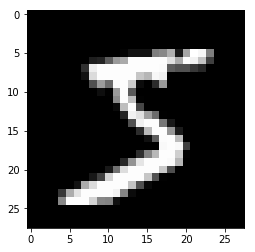

In [13]:
plt.imshow(train_data[0, ..., 0])

In [14]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data[0:1]},
    shuffle=False)
predictions = estimator.predict(input_fn=predict_input_fn)
for pred in predictions:
    print(pred)

INFO:tensorflow:Restoring parameters from tf_mnist_model_estimator/model.ckpt-1200
{'numbers': 5}


In [15]:
# Restore model to look at the graph.
import tensorflow as tf
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('tf_mnist_model_estimator/model.ckpt-1200.meta')
saver.restore(sess,tf.train.latest_checkpoint('tf_mnist_model_estimator/'))
show_graph(sess.graph)

INFO:tensorflow:Restoring parameters from tf_mnist_model_estimator/model.ckpt-1200
